# PCA and SVD on Amazon Data

In [15]:
%matplotlib inline

import pandas as pd
from datetime import datetime
import numpy as np
import os

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

import plotly
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

## Load data

In [16]:
## Custom plotly plot styling

# Remove the red color in discrete color scale
px.colors.qualitative.Plotly = px.colors.qualitative.Plotly[:1] + px.colors.qualitative.Plotly[2:]

pio.templates["custom"] = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor="rgba(0, 0, 0, 0)",
        font=dict(color="lightgreen"),
        colorscale=dict(sequential="Viridis"),
        colorway=px.colors.qualitative.Plotly)
)

pio.templates.default = "plotly+custom"

# Settings for plot rendering, makes work with HTML output + jupyer lab + static output
pio.renderers.default = "plotly_mimetype+notebook_connected+png"

In [22]:
data_path = os.path.normpath("../data/products_cleaned.csv")
df_az = pd.read_csv(data_path, dtype={"Category": "category"}, parse_dates=["Date Scraped"])

print(df_az.dtypes)
df_az

Asin                       object
Name                       object
Image Url                  object
Is Best Seller               bool
Stars                     float64
Reviews                   float64
Url                        object
Price                     float64
Date Scraped       datetime64[ns]
List Price                float64
Bought In Month           float64
Category                 category
dtype: object


,Asin,Name,Image Url,Is Best Seller,Stars,Reviews,Url,Price,Date Scraped,List Price,Bought In Month,Category
0,B0B8GTTK6V,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/71zksDvWH-...,False,5.0,1.0,https://www.amazon.com/Apple-Cellular-Graphite...,878.00,2024-02-01,878.00,NaN,NaN
1,B0CSVG1668,AppleWatch Ultra 2 [GPS + Cellular 49mm] Smart...,https://m.media-amazon.com/images/I/81k6R2uh1J...,False,NaN,0.0,https://www.amazon.com/Apple-Cellular-Smartwat...,799.00,2024-02-01,799.00,NaN,NaN
2,B09HF4LPR5,AppleWatch Series 7 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/91Kd2PB5Qs...,False,4.6,433.0,https://www.amazon.com/Apple-Cellular-Graphite...,799.00,2024-02-01,799.00,NaN,NaN
3,B0BDHT39HM,AppleWatch Ultra [GPS + Cellular 49mm] Smart w...,https://m.media-amazon.com/images/I/91jzT-Hi-T...,False,4.3,32.0,https://www.amazon.com/Apple-Cellular-Titanium...,799.00,2024-02-01,799.00,NaN,NaN
4,B0BHGJLX6W,AppleWatch Series 8 [GPS + Cellular 45mm] Smar...,https://m.media-amazon.com/images/I/61lCtY1nWP...,False,4.6,95.0,https://www.amazon.com/Apple-Cellular-Graphite...,791.98,2024-02-01,828.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1411185,B00R3LIKCO,American Flag Patriotic USA Classic 5 Panel Me...,https://m.media-amazon.com/images/I/71PDJFz6AA...,False,4.2,0.0,https://www.amazon.com/dp/B00R3LIKCO,14.95,2023-11-01,14.95,0.0,Men's Accessories
1411186,B098BQ7ZQ3,Men's Baseball Cap - H2O-DRI Line Up Curved Br...,https://m.media-amazon.com/images/I/812Tycexs4...,False,4.4,0.0,https://www.amazon.com/dp/B098BQ7ZQ3,33.99,2023-11-01,33.99,0.0,Men's Accessories
1411187,B07X1MVNT1,[4 Pack] Adjustable Eyeglasses and Sunglasses ...,https://m.media-amazon.com/images/I/61vvYW1S9J...,False,3.6,0.0,https://www.amazon.com/dp/B07X1MVNT1,8.54,2023-11-01,8.54,0.0,Men's Accessories
1411188,B08XLBG8V9,Ax2002 Aviator Sunglasses,https://m.media-amazon.com/images/I/51+yjD4F1x...,False,4.5,0.0,https://www.amazon.com/dp/B08XLBG8V9,54.36,2023-11-01,57.39,0.0,Men's Accessories


## Fit to numerical factors

In [83]:
df_pca = df_az.select_dtypes(include=[bool, np.number])
df_pca["Is Best Seller"] = df_pca["Is Best Seller"].astype(int)
df_pca = df_pca.fillna(0)


outlier_cols = ["Reviews", "Price", "List Price", "Bought In Month"]
q99 = df_pca[outlier_cols].quantile(0.99)

# Remove outliers and scale
df_pca_scaled = df_pca[~(df_pca[outlier_cols] >= q99).any(axis=1)]
df_pca_scaled = (df_pca_scaled-df_pca_scaled.min())/(df_pca_scaled.max()-df_pca_scaled.min())

pca = PCA(n_components=4)
pcs = pca.fit_transform(df_pca)
pcs = pcs[:, :2]
print(pca.explained_variance_, pca.explained_variance_ratio_)

pca_scaled = PCA(n_components=5)
pcs_scaled = pca_scaled.fit_transform(df_pca_scaled)
pcs_scaled = pcs_scaled[:, :3]
print(pca_scaled.explained_variance_, pca_scaled.explained_variance_ratio_)

[1.16530976e+07 6.97267573e+05 2.29536480e+05 1.09780825e+02] [9.26318388e-01 5.54266166e-02 1.82461238e-02 8.72660644e-06]
[0.07510055 0.0346746  0.02254424 0.00675291 0.00408197] [0.52386047 0.24187108 0.1572563  0.04710463 0.02847362]


### Plotting

In [88]:
pc_names = ["PC1", "PC2", "PC3", "PC4", "PC5"]
pc_names[:-2]

['PC1', 'PC2', 'PC3']

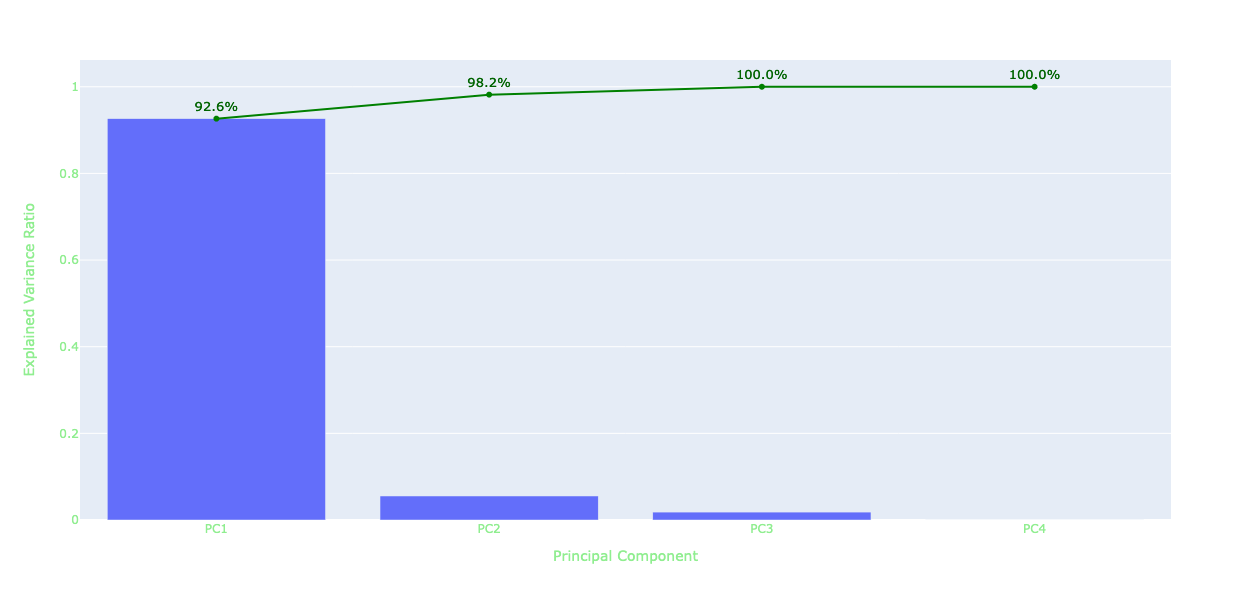

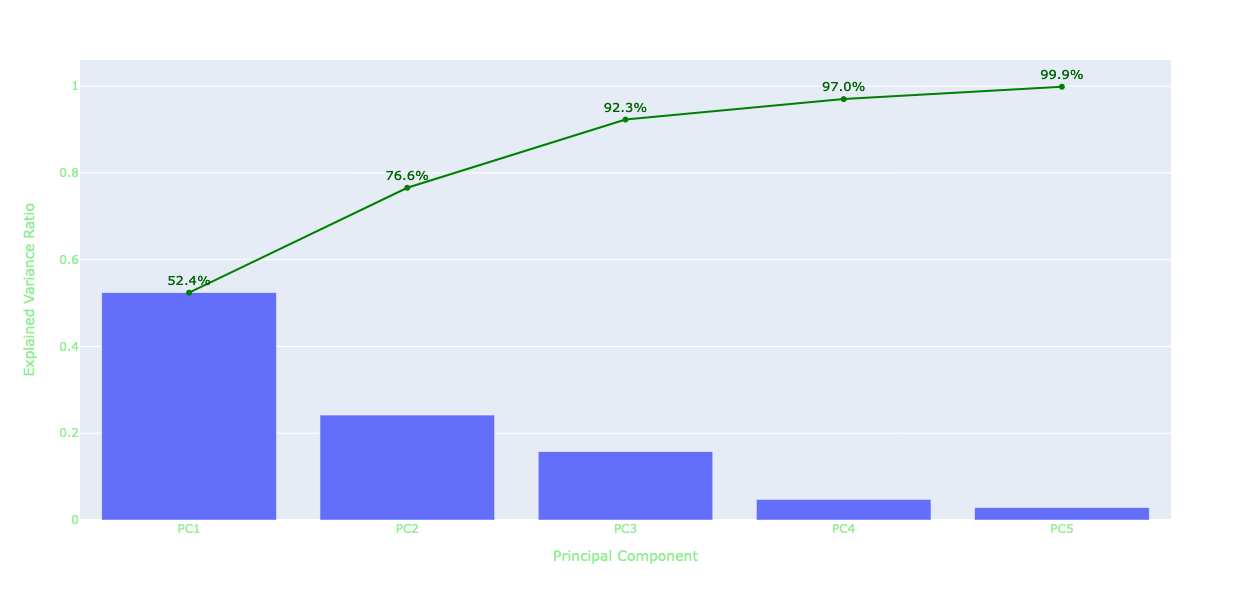

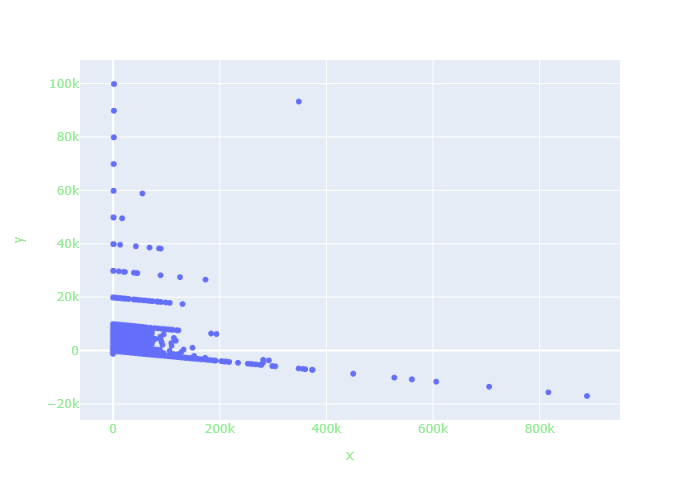

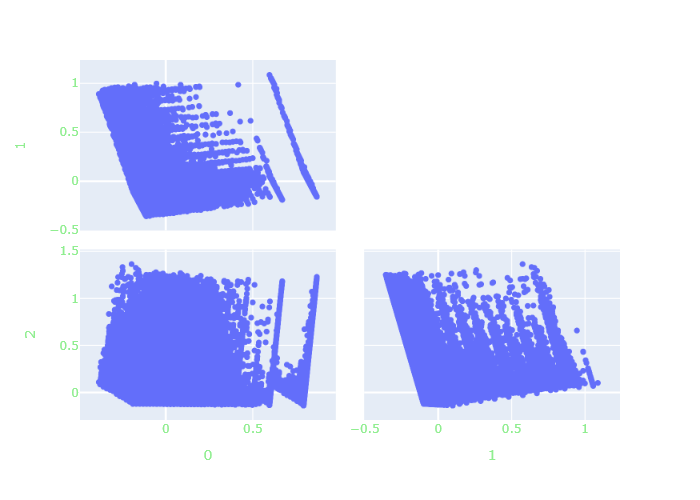

In [107]:
fig = px.bar(x=["PC1", "PC2", "PC3", "PC4"], y=pca.explained_variance_ratio_)
fig.add_scatter(x=["PC1", "PC2", "PC3", "PC4"], 
                y=np.cumsum(pca.explained_variance_ratio_), 
                mode="lines+markers+text", 
                texttemplate="%{y:.1%}",
                textposition="top center",
                textfont=dict(color="darkgreen", size=13),
                line_color="green")
fig.update_layout(showlegend=False, height=600, width=500, xaxis_title="Principal Component", yaxis_title="Explained Variance Ratio")
fig.show()

fig = px.bar(x=["PC1", "PC2", "PC3", "PC4", "PC5"], y=pca_scaled.explained_variance_ratio_)
fig.add_scatter(x=["PC1", "PC2", "PC3", "PC4", "PC5"], 
                y=np.cumsum(pca_scaled.explained_variance_ratio_), 
                mode="lines+markers+text", 
                texttemplate="%{y:.1%}",
                textposition="top center",
                textfont=dict(color="darkgreen", size=13),
                line_color="green"
               )
fig.update_layout(showlegend=False, height=600, width=500, xaxis_title="Principal Component", yaxis_title="Explained Variance Ratio")
fig.show()

fig = px.scatter(x=pcs[:, 0], y=pcs[:, 1])
fig.show(renderer="png")

fig = px.scatter_matrix(pcs_scaled, labels = pc_names[:-2], dimensions=range(3))
fig.update_traces(diagonal_visible=False, showupperhalf=False)
fig.show(renderer="png")

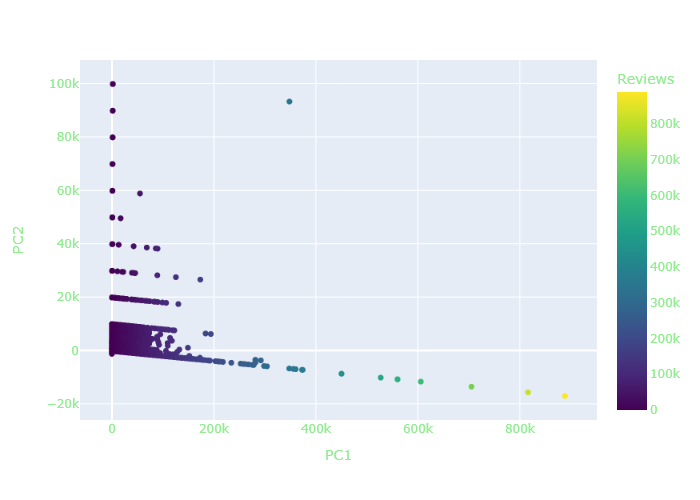

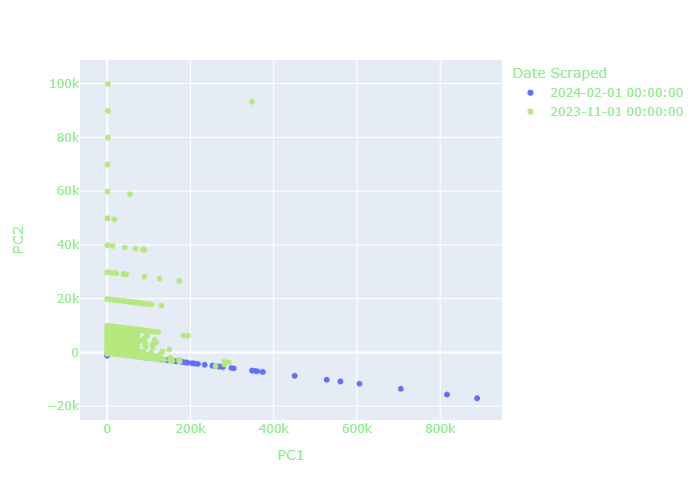

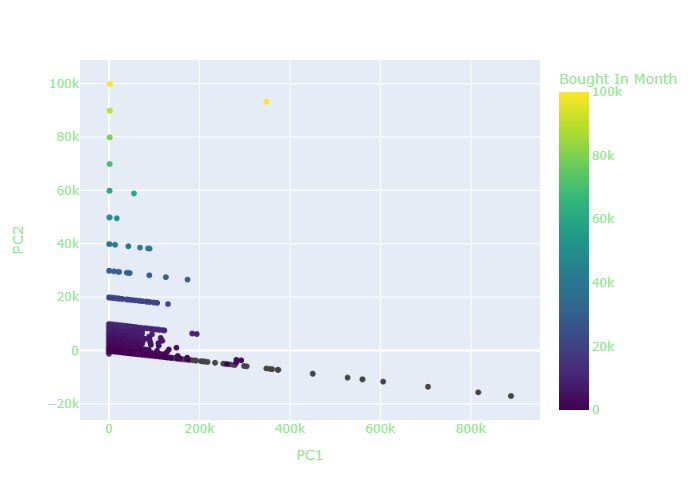

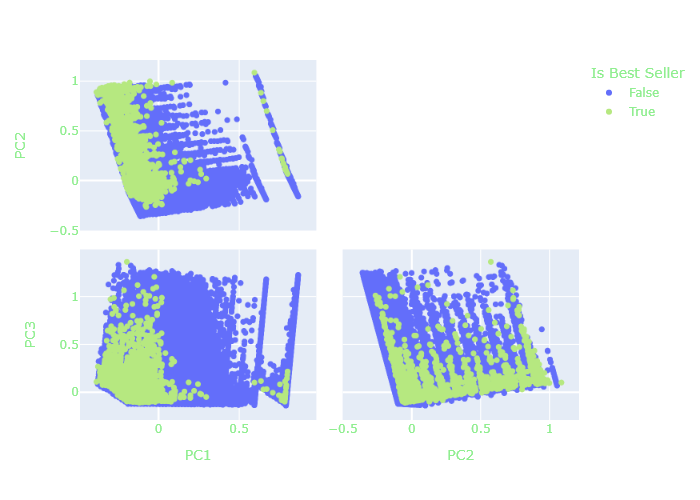

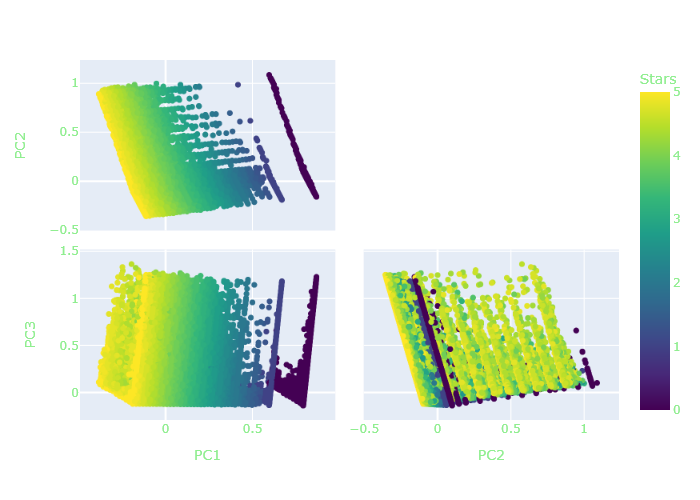

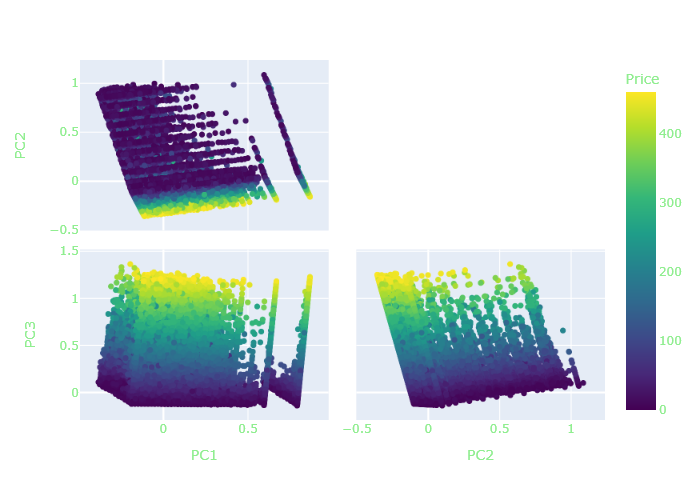

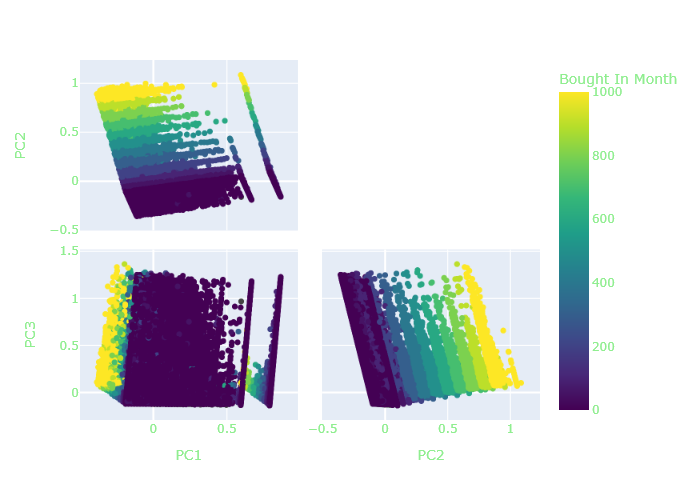

In [108]:
df_pcs = pd.concat([df_az, pd.DataFrame(pcs, columns=["PC1", "PC2"])], axis=1)
df_pcs_scaled = pd.DataFrame(pcs_scaled, columns=["PC1", "PC2", "PC3"], index=df_pca_scaled.index).join(df_az, how="inner")


for i, f in enumerate(["Reviews", "Date Scraped", "Bought In Month"]):
    fig = px.scatter(df_pcs, x="PC1", y="PC2", color=f)
    fig.show(renderer="png")

for f in ["Is Best Seller", "Stars", "Price", "Bought In Month"]:
    fig = px.scatter_matrix(df_pcs_scaled, dimensions=["PC1", "PC2", "PC3"], color=f)
    fig.update_traces(diagonal_visible=False, showupperhalf=False)
    fig.show(renderer="png")




## Fit categorical variable

In [78]:
txt_transformer = TfidfVectorizer(input="content", strip_accents="ascii")
txt_encoded = txt_transformer.fit_transform(df_az["Category"].cat.add_categories([""]).fillna(""))
arr_pca_cat = hstack([df_pca.to_numpy(), txt_encoded])

In [82]:
pca_cat = TruncatedSVD(n_components=4)
pcs_cat = pca_cat.fit_transform(arr_pca_cat)
pcs_cat = pcs_cat[:, :2]
print(pca_cat.explained_variance_, pca_cat.explained_variance_ratio_)

[1.16529574e+07 6.97155866e+05 2.29778455e+05 1.09427669e+02] [9.26307830e-01 5.54177719e-02 1.82653702e-02 8.69853918e-06]


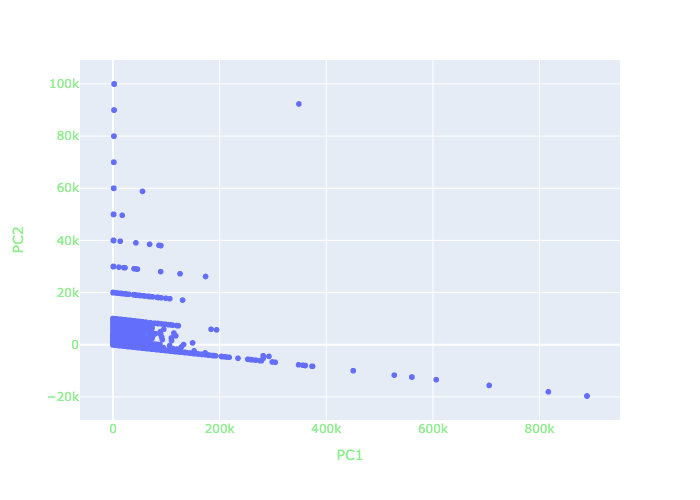

In [84]:
fig = px.scatter(x=pcs_cat[:, 0], y=pcs_cat[:, 1])
layout(fig)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show(renderer="png")

In [77]:
df_pca.to_numpy().shape

(1411190, 6)